# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, f1_score, plot_roc_curve
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

from operator import itemgetter, attrgetter

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import missingno

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


----

# Import data

In [2]:
# import data as csv file form data folder 
df_churn = pd.read_csv('../../data/Churn_Modelling.csv')

In [3]:
# checking the head of dataset 
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# getting info of dataset
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


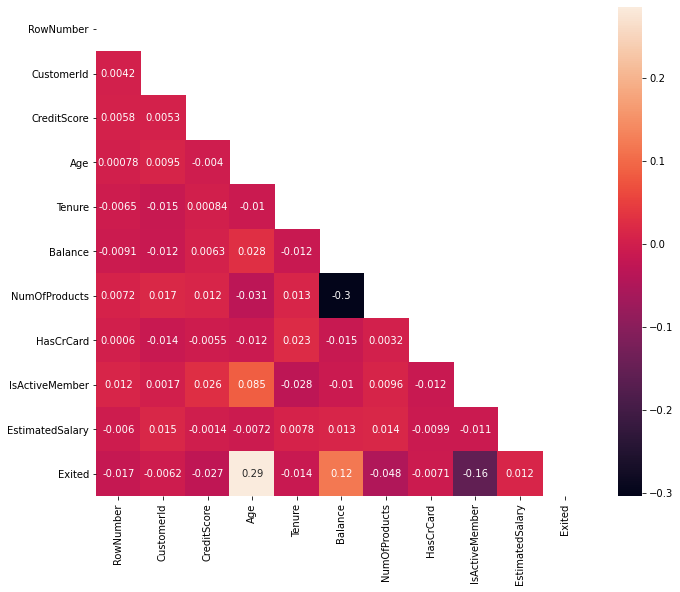

In [5]:
# Using hitmap to show the correlation between numerical columns and the target 
corr = df_churn.corr()
# The mask is not necessary, but corr() has duplicate values on either side of the diagonal
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11, 9))
sns.heatmap(df_churn.corr(), mask=mask, annot = True);

There are 3 numerical columns, Age,Balance and Gender whith the most correlation with the target(Exited).
I will show some future engineering on these columns.

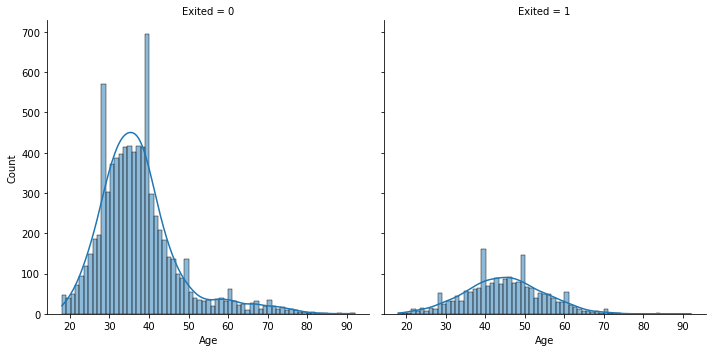

In [6]:
# Distribution of Age vs target
sns.displot(data=df_churn, x='Age', col='Exited', kde=True);
#plt.savefig('Age Contribution.png');

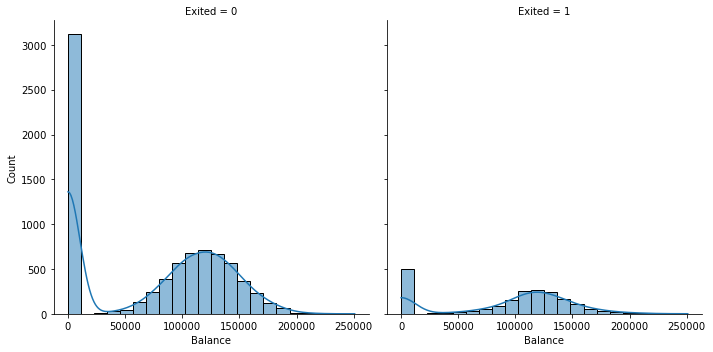

In [7]:
# Distribution of Balance vs target
sns.displot(data=df_churn, x='Balance', col='Exited', kde=True);
#plt.savefig('Balance Contribution.png');

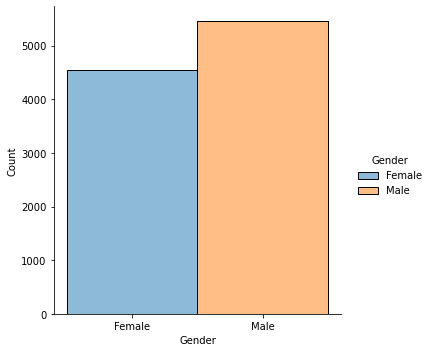

In [8]:
sns.displot(df_churn, x='Gender', hue='Gender');
#plt.savefig('Gender count.png')

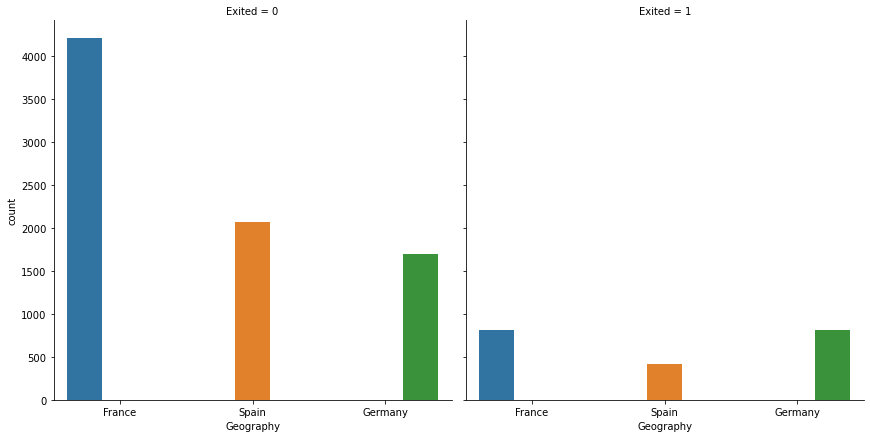

In [132]:
# distribution of countries vs exited
g = sns.catplot(x='Geography', hue='Geography', col='Exited',
                data=df_churn, kind="count",
                height=6, aspect=1);
#plt.savefig('Geography count.png')

In [9]:
# Changing  Gender column from categorical to binary(Numerical)
df_churn['Gender'] = df_churn['Gender'].map({'Female': 1, 'Male': 0})
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


In [10]:
# Dropping Useless columns 
# These columns are just personal information about customers
df_churn.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


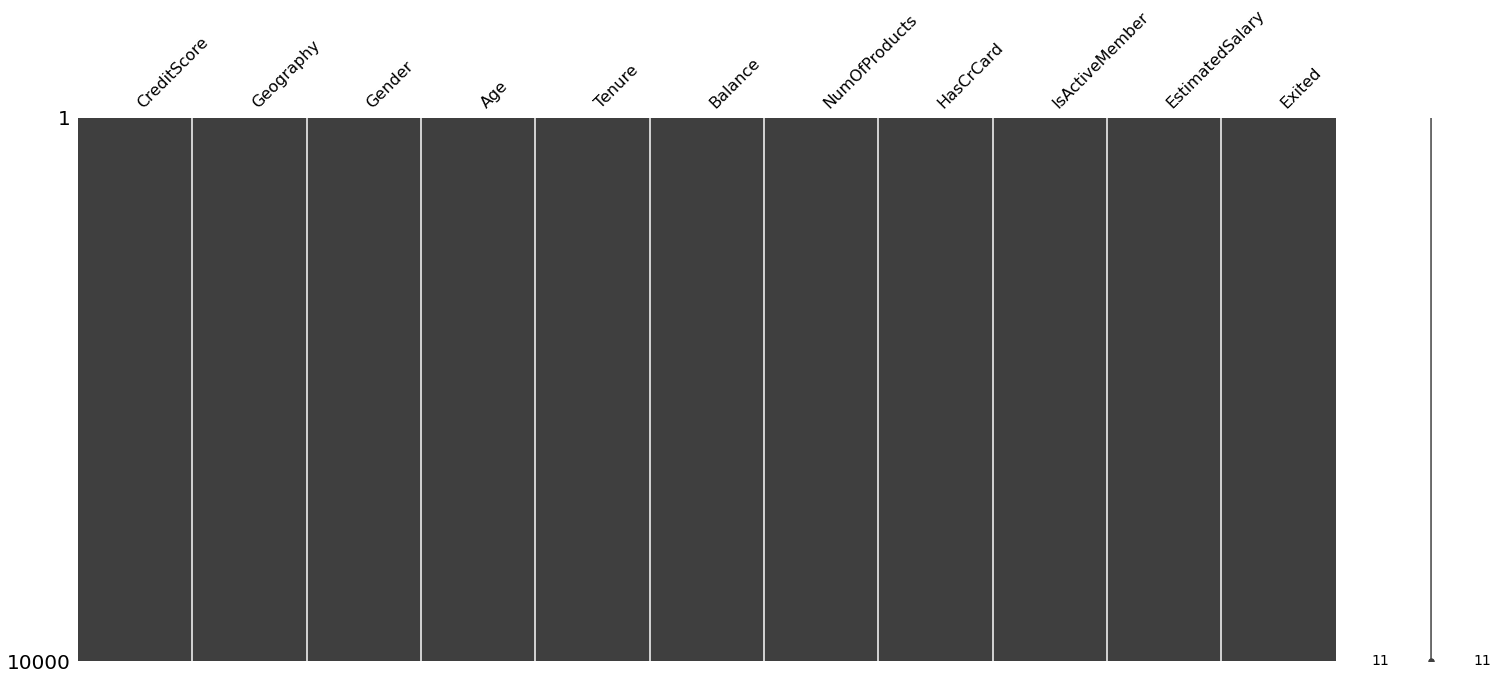


Preview of data with null values:
xxxxxxxxxxxxx
Empty DataFrame
Columns: [CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary, Exited]
Index: []


In [11]:
# generate preview of entries with null values
if len(df_churn[df_churn.isnull().any(axis=1)] != 0):
    print("\nPreview of data with null values:\nxxxxxxxxxxxxx")
    print(df_churn[df_churn.isnull().any(axis=1)].head(3))
missingno.matrix(df_churn)
plt.show()
print("\nPreview of data with null values:\nxxxxxxxxxxxxx")
print(df_churn[df_churn.isnull().any(axis=1)].head(3))

In [12]:
# generate count statistics of duplicate entries
if len(df_churn[df_churn.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df_churn[df_churn.duplicated()]))
    print(df_churn[df_churn.duplicated(keep=False)].sort_values(by=list(df_churn.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


## It looks like we have Heavy Imbalance target 
- I will take care of this imbalance later 

In [13]:
df_churn.Exited.value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

/Users/alirezakarimi/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


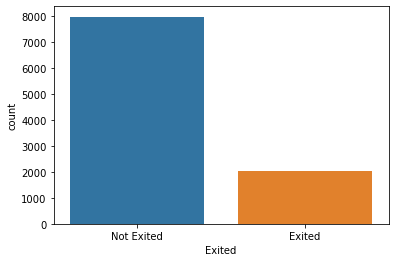

In [14]:
imbal = sns.countplot(df_churn['Exited'])
imbal.set_xticklabels(['Not Exited','Exited'])
plt.show();

In [15]:
df_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,1,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,1,41,1,83807.86,1,0,1,112542.58,0
2,502,France,1,42,8,159660.80,3,1,0,113931.57,1
3,699,France,1,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,1,43,2,125510.82,1,1,1,79084.10,0


In [16]:
# making Exited as our target 
# Dropping the original Exited column from data frame
X= df_churn.drop('Exited', axis=1)
y = df_churn.Exited

In [17]:
# type of data in our dataset
X.dtypes.value_counts()

int64      7
float64    2
object     1
dtype: int64

In [18]:
# split our dataset to training and test set.
# I do not touch the test set untill the last part 
# which is making the best training model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)
print(X_train.shape)
print(y_train.shape)

(8000, 10)
(8000,)


In [19]:
X_train.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

# Dealing with Categorical Columns 

In [20]:
# dropping the only object column 
# making dataset only numerical
X_tr_num = X_train.drop(['Geography'], axis=1)
X_tr_num

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9254,686,0,32,6,0.00,2,1,1,179093.26
1561,632,0,42,4,119624.60,2,1,1,195978.86
1670,559,0,24,3,114739.92,1,1,0,85891.02
6087,561,1,27,9,135637.00,1,1,0,153080.40
6669,517,0,56,9,142147.32,1,0,0,39488.04
...,...,...,...,...,...,...,...,...,...
5734,768,0,54,8,69712.74,1,1,1,69381.05
5191,682,1,58,1,0.00,1,1,1,706.50
5390,735,1,38,1,0.00,3,0,0,92220.12
860,667,0,43,8,190227.46,1,1,0,97508.04


In [21]:
# using One Hot Encoder to cahnge the only object(categorical) column to binary

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore') # instantiate the function

X_tr_cat = X_train[['Geography']] # use the numerical dataset

X_tr_oh = pd.DataFrame(ohe.fit_transform(X_tr_cat), columns=ohe.get_feature_names(X_tr_cat.columns), index=X_tr_cat.index) # create new dataset 
X_tr_ = X_tr_num.join(X_tr_oh) # join Two dataset
X_tr_

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
9254,686,0,32,6,0.00,2,1,1,179093.26,1.0,0.0,0.0
1561,632,0,42,4,119624.60,2,1,1,195978.86,0.0,1.0,0.0
1670,559,0,24,3,114739.92,1,1,0,85891.02,0.0,0.0,1.0
6087,561,1,27,9,135637.00,1,1,0,153080.40,1.0,0.0,0.0
6669,517,0,56,9,142147.32,1,0,0,39488.04,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,768,0,54,8,69712.74,1,1,1,69381.05,1.0,0.0,0.0
5191,682,1,58,1,0.00,1,1,1,706.50,1.0,0.0,0.0
5390,735,1,38,1,0.00,3,0,0,92220.12,1.0,0.0,0.0
860,667,0,43,8,190227.46,1,1,0,97508.04,1.0,0.0,0.0


# Scaling data train

In [22]:
# we scale our data to avoid the power of bigger numbers.
ss = StandardScaler() # instantiate the function
X_train_sc = pd.DataFrame(ss.fit_transform(X_tr_), index=X_tr_.index, columns=X_tr_.columns)
X_train_sc

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
9254,0.356500,-0.913248,-0.655786,0.345680,-1.218471,0.808436,0.649203,0.974817,1.367670,1.001501,-0.579467,-0.576388
1561,-0.203898,-0.913248,0.294938,-0.348369,0.696838,0.808436,0.649203,0.974817,1.661254,-0.998501,1.725723,-0.576388
1670,-0.961472,-0.913248,-1.416365,-0.695393,0.618629,-0.916688,0.649203,-1.025834,-0.252807,-0.998501,-0.579467,1.734942
6087,-0.940717,1.094993,-1.131148,1.386753,0.953212,-0.916688,0.649203,-1.025834,0.915393,1.001501,-0.579467,-0.576388
6669,-1.397337,-0.913248,1.625953,1.386753,1.057449,-0.916688,-1.540351,-1.025834,-1.059600,1.001501,-0.579467,-0.576388
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.207474,-0.913248,1.435808,1.039728,-0.102301,-0.916688,0.649203,0.974817,-0.539860,1.001501,-0.579467,-0.576388
5191,0.314989,1.094993,1.816097,-1.389442,-1.218471,-0.916688,0.649203,0.974817,-1.733882,1.001501,-0.579467,-0.576388
5390,0.865009,1.094993,-0.085351,-1.389442,-1.218471,2.533560,-1.540351,-1.025834,-0.142765,1.001501,-0.579467,-0.576388
860,0.159323,-0.913248,0.390011,1.039728,1.827259,-0.916688,0.649203,-1.025834,-0.050826,1.001501,-0.579467,-0.576388


# Resampling to solve imbalance data
- using over sampling technique(Smote)

In [23]:
ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
X_ros, y_ros = ros.fit_resample(X_train_sc, y_train)

print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 6356, 1: 1644})
Resample dataset shape Counter({0: 6356, 1: 6356})


-----

## Helper function to get cross_val_score

In [24]:
def model_output(model, X_t, X_val, y_t, y_val):
    '''Can be used on final test and train validation''
    input:   model, X_t, X_val, y_t, y_val
    or 
    input:   model, X_train, X_test, y_train, y_test
    '''
    model.fit(X_t, y_t)
    y_hat = model.predict(X_val)
    print(f'''The Cross Val f1 score is: {cross_val_score(estimator = model, X = X_t,y = y_t, cv = 3, scoring = 'f1').mean()}''')
    print(f'The test Accuracy is: {accuracy_score(y_val, y_hat)}')
    print(confusion_matrix(y_val, y_hat))
    print(classification_report(y_val, y_hat))
    return

# Making pipeline
- using pipeline to make our models
- with this pipeline, I can make all models and use this pipeline to predict our test set as well.

## Logistic Regression models
- first simple model

In [25]:
# use all previous data engineering to make pipeline
pip_line_lg = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('lg', LogisticRegression(random_state=42))
])

In [26]:
# fitting model(pipeline) into train set
pip_line_lg.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('lg', LogisticRegression(random_state=42))])

In [27]:
# getting the average of f1 score 
cross_val_score(pip_line_lg, X_train, y_train, cv=3, scoring='f1').mean()

0.4893211212449431

In [28]:
# checking the accuracy score
cross_val_score(pip_line_lg, X_train, y_train, cv=3, scoring='accuracy')

array([0.69066367, 0.71541057, 0.71267817])

In [29]:
# using helper function to predict 
model_output(pip_line_lg, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.4893211212449431
The test Accuracy is: 0.717
[[1153  454]
 [ 112  281]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1607
           1       0.38      0.72      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.74      2000



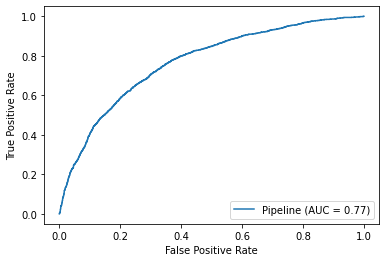

In [30]:
plot_roc_curve(pip_line_lg, X_train, y_train);

# Making helper function to plot confusion matrix

In [31]:
def confusion_matrix_info(model, X_train, y_train, save_path=None):
    '''
    Creates a confusion matrix for a given model
    Parameters
    ----------
    model: an estimator
    X_train: training  dataset
    y_train: training dataset
    Returns
    -------
    A confusion matrix of given model
    '''
    fig, axes = plt.subplots(figsize=(13,8))
    #axes.set_title("Model Validation", fontsize=20)
    x_tick_marks = ['Predicted To stay', 'Predicted To leave']
    y_tick_marks = ['Stayed', 'Exited']
    
    plot_confusion_matrix(model, X_train, y_train, ax=axes, cmap='Blues', display_labels=y_tick_marks)
    plt.xticks([0,1], x_tick_marks)
    plt.title('First logistic Regression  Model')
    
    label_font = {'size':'20'}
    axes.set_xlabel('', fontdict=label_font)
    axes.set_ylabel('', fontdict=label_font)
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16
    
    confusion_matrix = plt.show()
    if save_path:
        plt.savefig(save_path, transparent=True)
    return confusion_matrix, fig

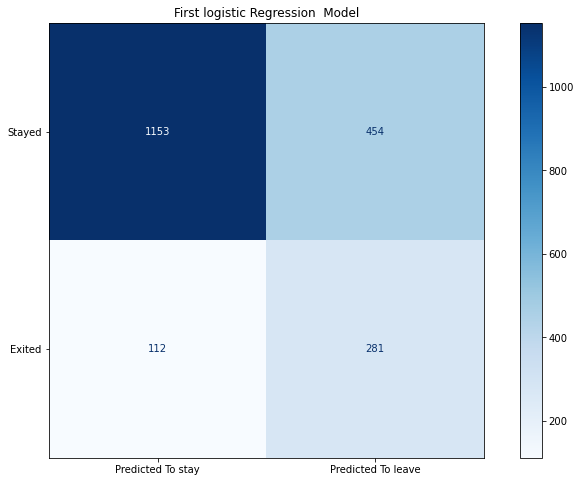

In [32]:
confusion_matrix_info(pip_line_lg, X_test, y_test);

In [33]:
# using pipeloine to make the secong logistic regression 
pip_line_lg1 = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('lg', LogisticRegression(C=.5, class_weight='balanced', random_state=42,  penalty='l1',solver='liblinear'))
])

In [34]:
# fitting model(pipeline) into train set
pip_line_lg1.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('lg',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [35]:
# getting the average of f1 score
cross_val_score(pip_line_lg1, X_train, y_train, cv=3, scoring='f1')

array([0.47558656, 0.51000646, 0.48178138])

In [36]:
# checking the accuracy score
cross_val_score(pip_line_lg1, X_train, y_train, cv=3, scoring='accuracy')

array([0.68991376, 0.71541057, 0.71192798])

In [37]:
# using helper function to predict 
model_output(pip_line_lg1, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.4891247963498229
The test Accuracy is: 0.717
[[1153  454]
 [ 112  281]]
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1607
           1       0.38      0.72      0.50       393

    accuracy                           0.72      2000
   macro avg       0.65      0.72      0.65      2000
weighted avg       0.81      0.72      0.74      2000



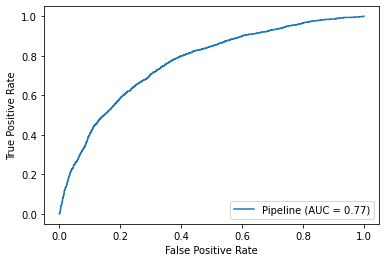

In [38]:
plot_roc_curve(pip_line_lg1, X_train, y_train);

----

## Random Forest models

In [39]:
# using pipiline to make Random Forest model
pip_line_rf = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [40]:
# fitting model(pipeline) into train set
pip_line_rf.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42))])

In [41]:
# getting the average of f1 score
cross_val_score(pip_line_rf, X_train, y_train, cv=3, scoring='f1').mean()

0.6017686728771269

In [42]:
# checking the accuracy score
cross_val_score(pip_line_rf, X_train, y_train, cv=3, scoring='accuracy')

array([0.85564304, 0.85714286, 0.84996249])

In [43]:
# using helper function to predict 
model_output(pip_line_rf, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.6017686728771269
The test Accuracy is: 0.858
[[1500  107]
 [ 177  216]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1607
           1       0.67      0.55      0.60       393

    accuracy                           0.86      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



In [44]:
def confusion_matrix_info(model, X_train, y_train, save_path=None):
    '''
    Creates a confusion matrix for a given model
    Parameters
    ----------
    model: an estimator
    X_train: training  dataset
    y_train: training dataset
    Returns
    -------
    A confusion matrix of given model
    '''
    fig, axes = plt.subplots(figsize=(13,8))
    #axes.set_title("Model Validation", fontsize=20)
    x_tick_marks = ['Predicted To stay', 'Predicted To leave']
    y_tick_marks = ['Stayed', 'Exited']
    
    plot_confusion_matrix(model, X_train, y_train, ax=axes, cmap='Blues', display_labels=y_tick_marks)
    plt.xticks([0,1], x_tick_marks)
    plt.title('First Random Forest  Model')
    
    label_font = {'size':'20'}
    axes.set_xlabel('', fontdict=label_font)
    axes.set_ylabel('', fontdict=label_font)
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16
    
    confusion_matrix = plt.show()
    if save_path:
        plt.savefig(save_path, transparent=True)
    return confusion_matrix, fig

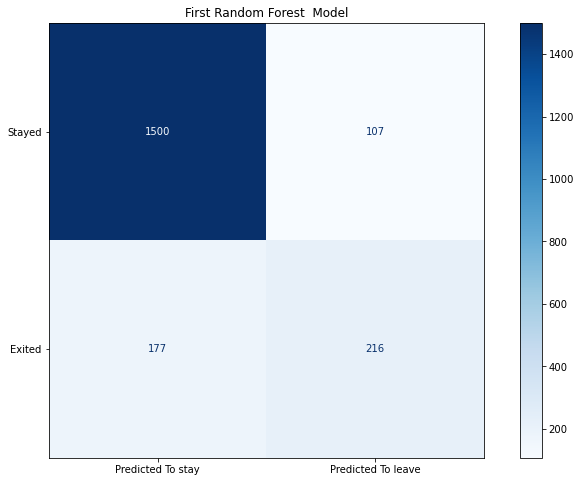

In [45]:
confusion_matrix_info(pip_line_rf, X_test, y_test);

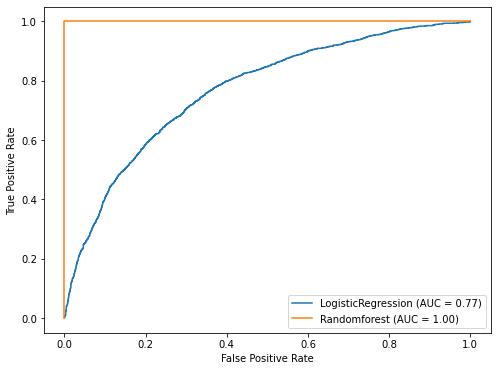

In [46]:
fig, ax = plt.subplots(figsize=(8,6))


plot_roc_curve(pip_line_lg, X_train, y_train, ax=ax, name='LogisticRegression' )
plot_roc_curve(pip_line_rf, X_train, y_train, ax=ax, name='Randomforest');


In [47]:
# using pipiline to make Random Forest model with hyper tuning 
pip_line_rf1 = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('rf1', RandomForestClassifier
     (criterion='gini', random_state=42,class_weight='balanced' ))
])

In [48]:
# fitting model(pipeline) into train set
pip_line_rf1.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('rf1',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [49]:
# getting the average of f1 score
cross_val_score(pip_line_rf1, X_train, y_train, cv=3, scoring='f1').mean()

0.6017686728771269

In [50]:
# checking the accuracy score
cross_val_score(pip_line_rf1, X_train, y_train, cv=3, scoring='accuracy')

array([0.85564304, 0.85714286, 0.84996249])

In [51]:
# using helper function to predict 
model_output(pip_line_rf1, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.6017686728771269
The test Accuracy is: 0.858
[[1500  107]
 [ 177  216]]
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1607
           1       0.67      0.55      0.60       393

    accuracy                           0.86      2000
   macro avg       0.78      0.74      0.76      2000
weighted avg       0.85      0.86      0.85      2000



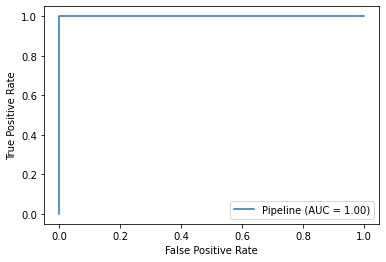

In [52]:
plot_roc_curve(pip_line_rf1, X_train, y_train);

# GridSearch

In [53]:
# using Grid Search function to Hyper-tun Parameters
param_grid = { 'rf1__criterion': ['gini', 'entropy'],'rf1__max_depth': [2,5,10],'rf1__n_estimators': [100, 1000]}

grid_search_rf =GridSearchCV(pip_line_rf1,param_grid=param_grid,cv=3, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train,y_train)# fiiting model into training set

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Geography_ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoding',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Geography'])])),
                                       ('scaler', StandardScaler()),
                                       ('sampling',
                                        RandomOverSampler(random_state=42)),
                                       ('rf1',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
   

In [54]:
# getting the best estimator
grid_search_rf.best_estimator_

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('rf1',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        n_estimators=1000, random_state=42))])

In [55]:
# getting the best score 
grid_search_rf.best_score_

0.6179687984707218

In [56]:
# predicting the f1 score 
f1_score(y_train, grid_search_rf.best_estimator_.predict(X_train))

0.7843137254901962

In [57]:
# using helper function to predict 
model_output(grid_search_rf, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.6174563801157579
The test Accuracy is: 0.8355
[[1392  215]
 [ 114  279]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1607
           1       0.56      0.71      0.63       393

    accuracy                           0.84      2000
   macro avg       0.74      0.79      0.76      2000
weighted avg       0.85      0.84      0.84      2000



----

# KNN

In [58]:
# using pipiline to make KNN model
pip_line_knn = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('knn', KNeighborsClassifier())
])

In [59]:
# fitting model(pipeline) into train set
pip_line_knn.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('knn', KNeighborsClassifier())])

In [60]:
# getting the average of f1 score
cross_val_score(pip_line_knn, X_train, y_train, cv=3, scoring='f1').mean()

0.4960258505949337

In [61]:
# checking the accuracy score
cross_val_score(pip_line_knn, X_train, y_train, cv=3, scoring='accuracy')

array([0.72628421, 0.73078365, 0.73143286])

In [62]:
# using helper function to predict 
model_output(pip_line_knn, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.4960258505949337
The test Accuracy is: 0.731
[[1213  394]
 [ 144  249]]
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1607
           1       0.39      0.63      0.48       393

    accuracy                           0.73      2000
   macro avg       0.64      0.69      0.65      2000
weighted avg       0.79      0.73      0.75      2000



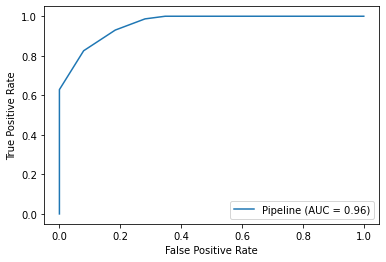

In [63]:
plot_roc_curve(pip_line_knn, X_train, y_train);

In [64]:
# using pipiline to make KNN model with hyper-tuning 
pip_line_knn1 = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('knn', KNeighborsClassifier(weights='distance', n_neighbors=3, n_jobs=-1))
])

In [65]:
# fitting model(pipeline) into train set
pip_line_knn1.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('knn',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=3,
                                      weights='distance'))])

In [66]:
# getting the average of f1 score
cross_val_score(pip_line_knn1, X_train, y_train, cv=3, scoring='f1').mean()

0.4880357059430422

In [67]:
# checking the accuracy score
cross_val_score(pip_line_knn1, X_train, y_train, cv=3, scoring='accuracy')

array([0.75103112, 0.75628046, 0.74456114])

In [68]:
# using helper function to predict 
model_output(pip_line_knn1, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.4880357059430422
The test Accuracy is: 0.76
[[1292  315]
 [ 165  228]]
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1607
           1       0.42      0.58      0.49       393

    accuracy                           0.76      2000
   macro avg       0.65      0.69      0.67      2000
weighted avg       0.80      0.76      0.77      2000



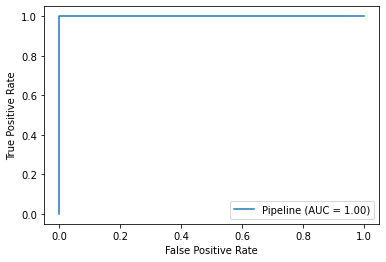

In [69]:
plot_roc_curve(pip_line_knn1, X_train, y_train);

-----

# Decision Tree

In [70]:
# using pipiline to make Decision Tree model 
pip_line_dectree = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('dt', DecisionTreeClassifier())
])

In [71]:
# fitting model(pipeline) into train set
pip_line_dectree.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('dt', DecisionTreeClassifier())])

In [72]:
# getting the average of f1 score
cross_val_score(pip_line_dectree, X_train, y_train, cv=3, scoring='f1').mean()

0.4863047748678544

In [73]:
# checking the accuracy score
cross_val_score(pip_line_dectree, X_train, y_train, cv=3, scoring='accuracy')

array([0.78177728, 0.78815148, 0.78769692])

In [74]:
# using helper function to predict 
model_output(pip_line_dectree, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.48398583775574533
The test Accuracy is: 0.802
[[1406  201]
 [ 195  198]]
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1607
           1       0.50      0.50      0.50       393

    accuracy                           0.80      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.80      0.80      0.80      2000



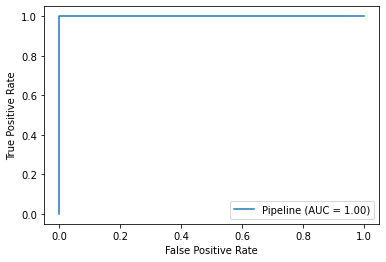

In [75]:
plot_roc_curve(pip_line_dectree, X_train, y_train);

In [76]:
# using pipiline to make Decision Tree model with hyper-tuning 
pip_line_dectree1 = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('dt1', DecisionTreeClassifier
     (criterion='entropy', splitter='random', max_depth=3, class_weight='balanced'))
])

In [77]:
# fitting model(pipeline) into train set
pip_line_dectree1.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('dt1',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        splitter='random'))])

In [78]:
# getting the average of f1 score
cross_val_score(pip_line_dectree1, X_train, y_train, cv=3, scoring='f1').mean()

0.4993982012050538

In [79]:
# checking the accuracy score
cross_val_score(pip_line_dectree1, X_train, y_train, cv=3, scoring='accuracy')

array([0.67566554, 0.59767529, 0.7411853 ])

In [80]:
# using helper function to predict 
model_output(pip_line_dectree1, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.5157861848247117
The test Accuracy is: 0.783
[[1302  305]
 [ 129  264]]
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      1607
           1       0.46      0.67      0.55       393

    accuracy                           0.78      2000
   macro avg       0.69      0.74      0.70      2000
weighted avg       0.82      0.78      0.80      2000



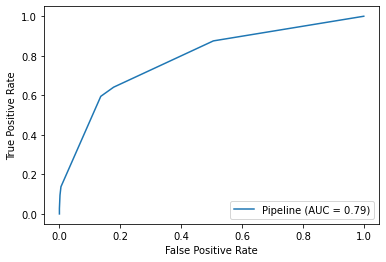

In [81]:
plot_roc_curve(pip_line_dectree1, X_train, y_train);

In [83]:
# using Grid Search function to Hyper-tun Parameters
param_grid = {'dt1__class_weight': ['balanced'],
             'dt1__splitter': ['best'],
             'dt1__max_depth': (21, 22, 23, 24, 25),
             'dt1__min_impurity_decrease':[.01, .02, .03, .04]}

grid_search_dectree1 =GridSearchCV(pip_line_dectree1,param_grid=param_grid,cv=3, scoring='f1', n_jobs=-1)

In [84]:
# fitting model(pipeline) into train set
grid_search_dectree1.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Geography_ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoding',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Geography'])])),
                                       ('scaler', StandardScaler()),
                                       ('sampling',
                                        RandomOverSampler(random_state=42)),
                                       ('dt1',
                                        DecisionTreeClassifier(class_weight='balanced',
                                                               criterion='entropy',
                           

In [85]:
# getting the best estimators
grid_search_dectree1.best_estimator_

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('dt1',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=21,
                                        min_impurity_decrease=0.01))])

In [86]:
# best f1 score
grid_search_dectree1.best_score_

0.5533733050168893

In [87]:
# best f1 score predict
f1_score(y_train, grid_search_dectree1.best_estimator_.predict(X_train))

0.5464089716058219

In [88]:
# using helper function to predict 
model_output(grid_search_dectree1, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.5533733050168893
The test Accuracy is: 0.7545
[[1228  379]
 [ 112  281]]
              precision    recall  f1-score   support

           0       0.92      0.76      0.83      1607
           1       0.43      0.72      0.53       393

    accuracy                           0.75      2000
   macro avg       0.67      0.74      0.68      2000
weighted avg       0.82      0.75      0.77      2000



# XGB

In [89]:
# using pipiline to make XGBoost model 
pip_line_xgb = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('xgb', XGBClassifier() )
])

In [90]:
# fitting model(pipeline) into train set
pip_line_xgb.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsa..., gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
         

In [91]:
# getting the average of f1 score
cross_val_score(pip_line_xgb, X_train, y_train, cv=3, scoring='f1').mean()

0.5829216775216821

In [92]:
# checking the accuracy score
cross_val_score(pip_line_xgb, X_train, y_train, cv=3, scoring='accuracy')

array([0.83352081, 0.83352081, 0.81995499])

In [93]:
# using helper function to predict 
model_output(pip_line_xgb, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.5829216775216821
The test Accuracy is: 0.828
[[1399  208]
 [ 136  257]]
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1607
           1       0.55      0.65      0.60       393

    accuracy                           0.83      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.84      0.83      0.83      2000



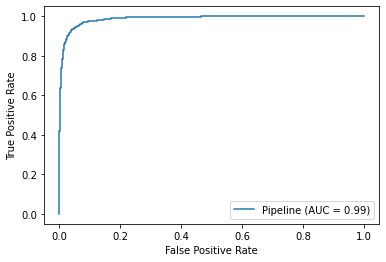

In [94]:
plot_roc_curve(pip_line_xgb, X_train, y_train);

In [95]:
# using Grid Search function to Hyper-tun Parameters
param_grid = {
    'xgb__max_depth': [2, 10, 1],
    'xgb__n_estimators': [60, 220, 40],
    'xgb__learning_rate': [0.1, 0.01, 0.05]
}

grid_search_xgb =GridSearchCV(pip_line_xgb,param_grid=param_grid,cv=3, scoring='f1', n_jobs=-1)

In [96]:
# fitting model(pipeline) into train set
grid_search_xgb.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Geography_ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoding',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Geography'])])),
                                       ('scaler', StandardScaler()),
                                       ('sampling',
                                        RandomOverSampler(random_state=42)),
                                       ('xgb',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      col

In [97]:
# getting the best estimators
grid_search_xgb.best_estimator_

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsa..., gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=nan,
        

In [98]:
# best f1 score
grid_search_xgb.best_score_

0.6031862264356543

In [99]:
# best f1 score predict
f1_score(y_train, grid_search_xgb.best_estimator_.predict(X_train))

0.6268878435256251

In [100]:
# using helper function to predict 
model_output(grid_search_xgb, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.5989522298770358
The test Accuracy is: 0.8095
[[1305  302]
 [  79  314]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1607
           1       0.51      0.80      0.62       393

    accuracy                           0.81      2000
   macro avg       0.73      0.81      0.75      2000
weighted avg       0.86      0.81      0.82      2000



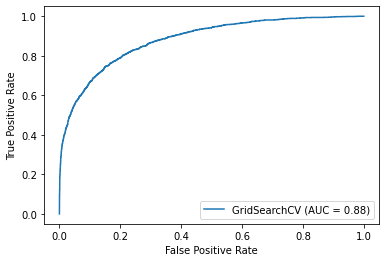

In [101]:
plot_roc_curve(grid_search_xgb, X_train, y_train);

In [102]:
# using pipiline to make XGBoost model with hyper-tuning 
pip_line_xgb1 = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('xgb1', XGBClassifier(scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=10))
])

In [103]:
# fitting model(pipeline) into train set
pip_line_xgb1.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('xgb1',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               cols...10, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
              

In [104]:
# getting the average of f1 score
cross_val_score(pip_line_xgb1, X_train, y_train, cv=3, scoring='f1').mean()

0.6014559892337052

In [105]:
# checking the accuracy score
cross_val_score(pip_line_xgb1, X_train, y_train, cv=3, scoring='accuracy')

array([0.80089989, 0.7960255 , 0.79144786])

In [106]:
# using helper function to predict 
model_output(pip_line_xgb1, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.6014559892337052
The test Accuracy is: 0.8045
[[1296  311]
 [  80  313]]
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      1607
           1       0.50      0.80      0.62       393

    accuracy                           0.80      2000
   macro avg       0.72      0.80      0.74      2000
weighted avg       0.86      0.80      0.82      2000



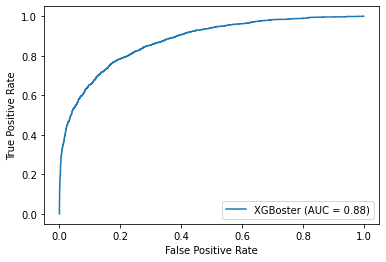

In [107]:
plot_roc_curve(pip_line_xgb1, X_train, y_train, name='XGBoster');

In [108]:
# using pipiline to make XGBoost model with hyper-tuning 
pip_line_xgb2 = Pipeline([
    ('Geography_ohe', ColumnTransformer([
        ('onehotencoding', OneHotEncoder
         (sparse=False, handle_unknown='ignore'),
         ['Geography'])
    ], remainder='passthrough')),
    ('scaler', StandardScaler()),
    ('sampling', RandomOverSampler(random_state=42)),
    ('xgb2', XGBClassifier(scale_pos_weight=1,
                      learning_rate=0.1,  
                      colsample_bytree = 0.3,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=3, 
                      gamma=0))
])

In [109]:
# fitting model(pipeline) into train set
pip_line_xgb2.fit(X_train, y_train)

Pipeline(steps=[('Geography_ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoding',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Geography'])])),
                ('scaler', StandardScaler()),
                ('sampling', RandomOverSampler(random_state=42)),
                ('xgb2',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               cols...a=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
              

In [110]:
# getting the average of f1 score
cross_val_score(pip_line_xgb2, X_train, y_train, cv=3, scoring='f1').mean()

0.5924046434321384

In [111]:
# checking the accuracy score
cross_val_score(pip_line_xgb2, X_train, y_train, cv=3, scoring='accuracy').mean()

0.8107493690070436

In [112]:
# using helper function to predict 
model_output(pip_line_xgb2, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.5924046434321384
The test Accuracy is: 0.8125
[[1345  262]
 [ 113  280]]
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1607
           1       0.52      0.71      0.60       393

    accuracy                           0.81      2000
   macro avg       0.72      0.77      0.74      2000
weighted avg       0.84      0.81      0.82      2000



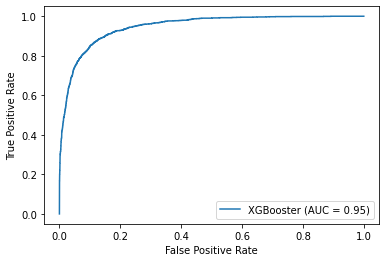

In [113]:
plot_roc_curve(pip_line_xgb2, X_train, y_train, name='XGBooster');

-----

# test set 

In [114]:
# using the best model to make the final model
# fit the model again
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('Geography_ohe',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoding',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Geography'])])),
                                       ('scaler', StandardScaler()),
                                       ('sampling',
                                        RandomOverSampler(random_state=42)),
                                       ('rf1',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
   

In [115]:
# make prediction on test set
grid_search_rf.predict(X_test)

array([0, 0, 0, ..., 1, 0, 1])

In [116]:
# using the predict of test set
y_hat_test = grid_search_rf.predict(X_test)

In [117]:
# getting the f1 score on test set
f1_score(y_test, y_hat_test)

0.629086809470124

In [118]:
# using helper function to predict 
model_output(grid_search_rf, X_train, X_test, y_train, y_test)

The Cross Val f1 score is: 0.6174563801157579
The test Accuracy is: 0.8355
[[1392  215]
 [ 114  279]]
              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1607
           1       0.56      0.71      0.63       393

    accuracy                           0.84      2000
   macro avg       0.74      0.79      0.76      2000
weighted avg       0.85      0.84      0.84      2000



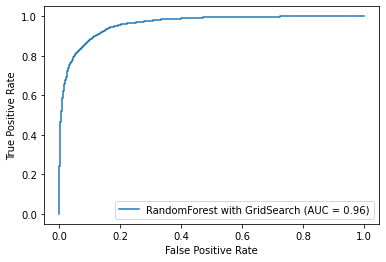

In [120]:
plot_roc_curve(grid_search_rf, X_train, y_train, name='RandomForest with GridSearch');

In [121]:
def confusion_matrix_info(model, X_train, y_train, save_path=None):
    '''
    Creates a confusion matrix for a given model
    Parameters
    ----------
    model: an estimator
    X_train: training  dataset
    y_train: training dataset
    Returns
    -------
    A confusion matrix of given model
    '''
    fig, axes = plt.subplots(figsize=(13,8))
    #axes.set_title("Model Validation", fontsize=20)
    x_tick_marks = ['Predicted To stay', 'Predicted To leave']
    y_tick_marks = ['Stayed', 'Exited']
    
    plot_confusion_matrix(model, X_train, y_train, ax=axes, cmap='Blues', display_labels=y_tick_marks)
    plt.xticks([0,1], x_tick_marks)
    plt.title('Final model with RandomForest GridSearch')
    
    label_font = {'size':'20'}
    axes.set_xlabel('', fontdict=label_font)
    axes.set_ylabel('', fontdict=label_font)
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16
    
    confusion_matrix = plt.show()
    if save_path:
        plt.savefig(save_path, transparent=True)
    return confusion_matrix, fig

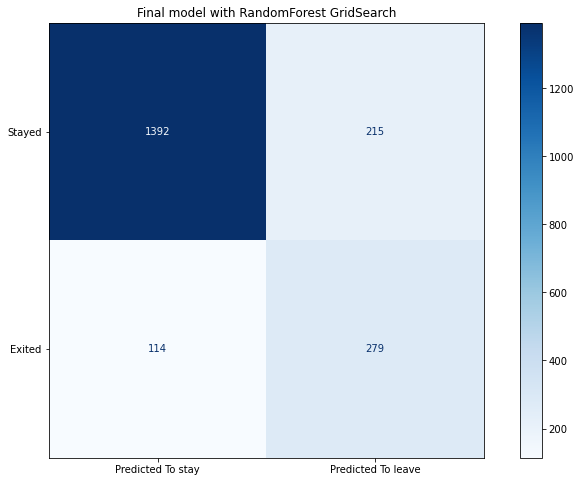

In [122]:
confusion_matrix_info(grid_search_rf, X_test, y_test);